In [362]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [363]:
!pwd

/content


# Creating the data frame

In [364]:
price_df = pd.read_csv('/car_prices_w_prices_scaled.csv', index_col=0)

In [365]:
features_df = pd.read_csv('/scaled_cleaned.csv')

## Merging features and prices

In [366]:
merged_df = price_df.merge(features_df, left_on="car_code", right_on="car_code", how="left")

In [367]:
merged_df.rename(columns=lambda x: x.strip(), inplace=True)

In [368]:
merged_df[merged_df.index == 87887 ]

,car_code,car_manufacturer,car_model,car_model_year,Year_x,Price_YoY,Next_YoY_Price,Next_YoY_Pr_Pred,calendar_year,Price_sd_scaled,...,Maximum power,Unit displacement,Trunk,USB connection,Gear speed transmissions,Urban,Year_y,Radio,Folding rear seat,Perimeter anti theft alarm
87887,441,Audi,A8 4.2 V8 Quattro,2003,1,0.749652,0.961737,0.917069,2004,-0.836267,...,0.167403,0.523084,0.033011,0.0,0.545455,0.062035,0.625,0.0,0.0,0.0


### making model first name feature

In [369]:
def take_first_word(word):
    return word.split(" ")[0]

merged_df["car_model_small"] = merged_df["car_model"].map(take_first_word)
merged_df.drop(columns="car_model", inplace=True)

# Model preprocessor

In [370]:
import numpy as np
from sklearn.model_selection import train_test_split

In [371]:
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder

# Model X and y - train test validade sets

In [372]:
X = merged_df.drop( columns=['car_code' , 'car_model_year',  'Next_YoY_Price', 'Next_YoY_Pr_Pred',
       'Price_sd_scaled' ])


In [373]:

num_feat = [feature for feature in X.select_dtypes(include='number').columns.tolist() if feature not in ["Year_x", "calendar_year" , "car_code", "car_model_year" , "CNW Index", "CNW Ranking", "CNW Ranking", "Devaluation" ] ]
#num_feat
categorical_features = list(merged_df.select_dtypes(include='object').columns)
categorical_features = [] # intentionaly removing these features ['car_manufacturer', 'car_model_small']
year_features = ["Year_x", "calendar_year" ]


In [374]:
#reiviewd after permutation analysis --> see heredown
num_feat = ['Price_YoY',
'Price R',
'Doors',
'Settings_Pickup truck',
'Length between the axis',
'Sidewall height',
'Weight',
'Car gearbox_Manual',
'Height',
'Maximum speed',
'Acceleration',
'Car payload',
'Width',
'Cylinder diameter',
'Fuel tank',
'Length',
'Year_y',
'Trunk',
'Road consumption',
'Light in the trunk',
'Specific power',
'Piston course',
'Reader score',
'Provenance']


In [375]:

# Impute then scale numerical values:
num_inputer = Pipeline([
    ('imputer', SimpleImputer(strategy="mean"))
    #('standard_scaler', StandardScaler())
])

standard_scaler = Pipeline([
    #('imputer', SimpleImputer(strategy="mean"))
    ('standard_scaler', StandardScaler())
])




# Encode categorical values
cat_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)




# Parallelize "num_transformer" and "cat_transfomer"
preprocessor = ColumnTransformer([
    ('cat_transformer', cat_transformer, categorical_features ), #,
    ('standard_scaler', standard_scaler, year_features ) ,
    ('num_inputer', num_inputer, num_feat  )  #numerical_columns
])


In [376]:
y = merged_df['Next_YoY_Price']
#y = merged_df["Next_Price_sd_scaled"]

In [377]:
from sklearn.model_selection import train_test_split

X = preprocessor.fit_transform(X)  #keep in mind, is not procedural good

# Split data into train, test and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 42  # TEST = 30%
)

# Use the same function above for the validation set
X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size = 0.5, random_state = 42  # TEST = 15%
)

#  XG Boost Model

In [378]:
from xgboost import XGBRegressor

In [379]:

#X_train_transformed = preprocessor.fit_transform(X_train)
#X_val_transformed = preprocessor.transform(X_val)
X.shape

(87891, 26)

In [380]:
X_train.shape
#X_train.shape

(61523, 26)

In [381]:
X_val.shape
#X_val.shape

(13184, 26)

In [382]:
from xgboost import XGBRegressor #commenting this out
"""
xgb_reg = XGBRegressor(max_depth=10, n_estimators=20, learning_rate=0.05)

xgb_reg.fit(X_train, y_train,
    # evaluate loss at each iteration
    eval_set=[(X_train, y_train), (X_val, y_val)],
    # stop iterating when eval loss increases 5 times in a row
    early_stopping_rounds=5
)

y_pred = xgb_reg.predict(X_val)

"""

'\nxgb_reg = XGBRegressor(max_depth=10, n_estimators=20, learning_rate=0.05)\n\nxgb_reg.fit(X_train, y_train,\n    # evaluate loss at each iteration\n    eval_set=[(X_train, y_train), (X_val, y_val)],  \n    # stop iterating when eval loss increases 5 times in a row\n    early_stopping_rounds=5 \n)\n\ny_pred = xgb_reg.predict(X_val)\n\n'

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


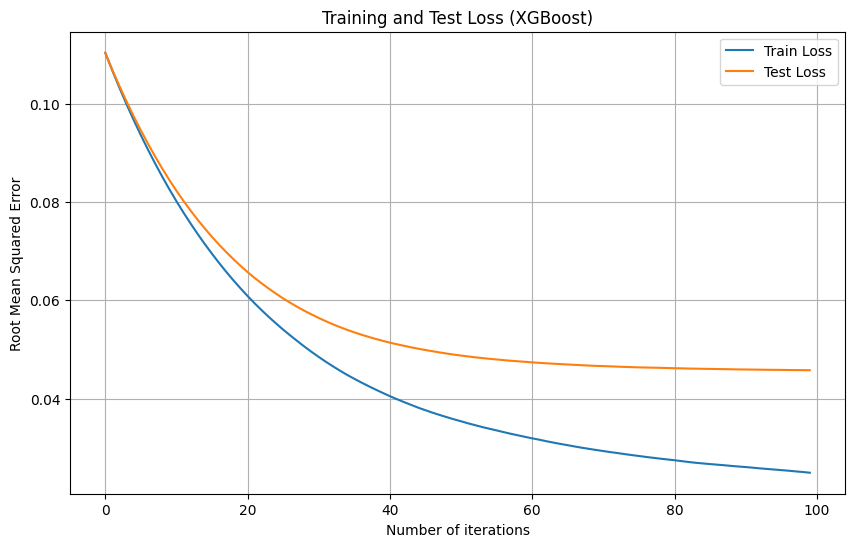

In [423]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming you have your X_train, y_train, X_test, and y_test data prepared

# Define the XGBoost regressor
xgb_regressor = xgb.XGBRegressor(max_depth=13,  learning_rate=0.04 , n_estimators=100 ) #  n_estimators=150 , scale_pos_weight = 1

# Fit the model with evaluation set
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_regressor.fit(X_train, y_train, eval_set=eval_set, eval_metric="rmse", verbose=False) #set verbose=True if you want to show al the results

# Extract training and validation loss from the model's history
results = xgb_regressor.evals_result()
train_loss = results['validation_0']['rmse']
test_loss = results['validation_1']['rmse']

# Plot the train and test loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Number of iterations')
plt.ylabel('Root Mean Squared Error')
plt.title('Training and Test Loss (XGBoost)')
plt.legend()
plt.grid()
plt.show()

In [184]:
#trying to grid search this
from sklearn.model_selection import GridSearchCV
# Instantiate model
model = xgb.XGBRegressor(n_estimators = 10)

# Hyperparameter Grid
grid = {
    'max_depth': [9, 10, 11],
    'learning_rate': [0.1, 0.05]
}

# Instantiate Grid Search
search = GridSearchCV(
    model,
    grid,
    scoring = 'neg_mean_squared_error',
    cv = 5,
    n_jobs=-1 # parallelize computation
)

# Fit data to Grid Search
search.fit(X_train, y_train , eval_metric="rmse", verbose=False);



/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


In [200]:
(search.best_score_  * -1) ** 0.5  #keep in mind: this gas less n_estimators than the definitive model

0.05985784112300065

In [201]:
search.best_params_

{'learning_rate': 0.1, 'max_depth': 11}

In [181]:
search.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [141]:
from sklearn.metrics import mean_squared_error

In [398]:
y_pred = xgb_regressor.predict(X_test)
#y_pred = model.predict(X_test)
y_pred

array([0.89607346, 0.8849079 , 0.9116545 , ..., 0.916897  , 0.9069996 ,
       0.955855  ], dtype=float32)

## Feature selection

In [331]:
from sklearn.inspection import permutation_importance


In [333]:
#preprocessor.get_feature_names_out()

In [384]:

# Fit model
model = xgb_regressor.fit(X_train, y_train)

# Performs Permutation
permutation_score = permutation_importance(model, X_train, y_train, n_repeats=8)

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((preprocessor.get_feature_names_out(),
                                        permutation_score.importances_mean)).T)
importance_df.columns=['feature','score decrease']

# Show the important features
importance_df.sort_values(by="score decrease", ascending = False)

,feature,score decrease
1,standard_scaler__calendar_year,1.717651
2,num_inputer__Price_YoY,0.198456
3,num_inputer__Price R,0.112204
0,standard_scaler__Year_x,0.057095
8,num_inputer__Weight,0.033264
6,num_inputer__Length between the axis,0.031599
5,num_inputer__Settings_Pickup truck,0.027431
4,num_inputer__Doors,0.026897
11,num_inputer__Maximum speed,0.025584
10,num_inputer__Height,0.024576


After analisys with all features, I kept the following top features in the model:



```
calendar_year
Price_YoY
Price R
Year_x
Doors
Settings_Pickup truck
Length between the axis
Sidewall height
Weight
Car gearbox_Manual
Height
Maximum speed
Acceleration
Car payload
Width
Cylinder diameter
Fuel tank
Length
Year_y
Trunk
Road consumption
Light in the trunk
Specific power
Piston course
Reader score
Provenance
```



## comparing model with naive model

In [424]:
y_pred = xgb_regressor.predict(X_test)
#y_pred = model.predict(X_test)
y_pred

array([0.8992692 , 0.87335914, 0.9088821 , ..., 0.9202106 , 0.90979326,
       0.9682035 ], dtype=float32)

In [425]:
mean_squared_error(y_test, y_pred) ** (0.5)   #model score: mean square error --> lower is better

0.04580033305214049

In [426]:
mean_squared_error(y_test, [y_test.mean()]*len(y_test)) ** (0.5)   #naive score: mean square error

0.11389767051634032

## Saving the model for later usage

In [427]:
import pickle

filename = 'xgb_reg_model.sav'
pickle.dump(xgb_reg, open(filename, 'wb'))


#xgb_reg.save('xgb.h5')

# Simple tester

In [224]:
car = merged_df[merged_df["car_model_year"] == 2015 ] [merged_df["calendar_year"] == 2022]#[merged_df.index == 23575 ]
car = merged_df[merged_df.index == 7780 ]
car[["car_code", "car_manufacturer", "car_model_small", "Next_YoY_Price" ]]

<ipython-input-224-00b585ced60a>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  car = merged_df[merged_df["car_model_year"] == 2015 ] [merged_df["calendar_year"] == 2022]#[merged_df.index == 23575 ]


,car_code,car_manufacturer,car_model_small,Next_YoY_Price
7780,3666,Peugeot,308,1.05607


In [225]:
car = car.drop( columns=['car_code' , 'car_model_year',  'Next_YoY_Price', 'Next_YoY_Pr_Pred', 'Price_sd_scaled' ])


#X = merged_df.drop( columns=['car_code' , 'car_model_year',  'Next_YoY_Price', 'Next_YoY_Pr_Pred',
#       'Price_sd_scaled' ])


#car["car_model_small"] = car["car_model"].map(take_first_word)
#car.drop(columns="car_model", inplace=True)
car

,car_manufacturer,Year_x,Price_YoY,calendar_year,Propulsion_Combustion,Propulsion_Electric,Propulsion_Hybrid,Propulsion_Light Hybrid,Propulsion_Plug-in hybrid,Car gearbox_Automated,...,Unit displacement,Trunk,USB connection,Gear speed transmissions,Urban,Year_y,Radio,Folding rear seat,Perimeter anti theft alarm,car_model_small
7780,Peugeot,7,1.19455,2022,1.0,0.0,0.0,0.0,0.0,0.0,...,0.400592,0.017406,1.0,0.545455,0.146402,0.839286,1.0,0.0,1.0,308


In [226]:
car_transformed = preprocessor.transform(car)

In [227]:
xgb_reg.predict(car_transformed)

array([1.0097748], dtype=float32)